# Genre Classification of Song Lyrics

## Comparison of Logistic Regression, Random Forest, Adaboost, and Naive Bayes Classifiers

### Jeremy Cui and Jason Stitt
### Northeastern University - Khoury College of Computer Science
### April 18, 2022

This project attempts to predict a song’s genre based on its lyrics. A project such as this one could aid many parties in the music industry. A model that correctly predicts song genre based on lyrics would enable artists to create music and publish it without having to indicate the genre itself. The model would then determine the genre to avoid mis-classifying a genre and keep music listeners happy. A correctly classified song would more effectively reach the listener who wants similar songs or a certain genre. The model could also be enhanced in the future to include sub-genres and produce even better recommendations as a result.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
from nltk.corpus import stopwords
import pandas as pd
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
from wordcloud import WordCloud

## Loading and Cleaning

In [6]:
lyrics_df = pd.read_csv("../raw/train2.csv")

In [7]:
lyrics_df['Lyric']

0        [Intro: Method Man w/ sample] + (Sunny valenti...
1        [Sean Paul:]. Aye. It's Sean Paul 'long side. ...
2        Beauty finds refuge in herself. Lovers wrapped...
3        You've changed your tune. many times since we'...
4        I got all these J's rolled up. And got all the...
                               ...                        
48488    Unforgettable face I can't think of her name. ...
48489    Shawty swing my way put that ass all in my fac...
48490    Born in caught out. Care out fear in. Gear in ...
48491    I've got nothing to say today. I used my words...
48492    Going far Getting nowhere. Going far The way y...
Name: Lyric, Length: 48493, dtype: object

In [8]:
lyrics_df.shape

(48493, 2)

In [9]:
val_df = pd.read_csv("../raw/raw_val2.csv")

### Remove stopwords
First step of preprocessing involves removing stopwords. The 'stopwords' package comes with common stopwords that we filter out from the raw data.

In [10]:
stop_word = stopwords.words('english')
stop_words = []
for word in stop_word:
    wo = re.sub("'", "", word)
    stop_words.append(wo)


Next, we process each lyric data.
1. Remove anything enclosed in parentheses or brackets in the lyrics data. In the raw train dataset provided, words enclosed in these signal the name of the artist whose line follows in songs with multiple artists.
2. Remove all punctuations from lyric data. Punctuations do not convey significant linguistic meaning to classification.
3. Remove trailing whitespaces.

In [11]:
# cleaning data
new_lyrics = []

# removes punctuations from each sample
for lyrics in lyrics_df['Lyric'].tolist():

    lyrics_n = re.sub("([\(\[]).*?([\)\]])", "", lyrics)
    lyrics_n2 = lyrics_n.translate(str.maketrans('', '', string.punctuation))
    lyrics_n3 = re.sub(' +', ' ', lyrics_n2)
    #lyrics_n4 = re.sub(r'[0-9]+', '', lyrics_n3)
    lyrics_train_processed = lyrics_n3

    new_list_song = []
    for word in lyrics_train_processed.split():
        if word.lower() not in stop_words:
            new_list_song.append(word)
            new_song = " ".join(new_list_song)

    new_lyrics.append(new_song)

lyrics_df['Lyric'] = new_lyrics

Perform the same on procedure on the validation set.

In [12]:
# cleaning test data
new_lyrics_ = []

for lyrics in val_df['Lyric'].tolist():

    lyrics_n = re.sub("([\(\[]).*?([\)\]])", "", lyrics)
    lyrics_n2 = lyrics_n.translate(str.maketrans('', '', string.punctuation))
    lyrics_n3 = re.sub(' +', ' ', lyrics_n2)
    lyrics_val_processed = lyrics_n3

    new_list_song = []
    for word in lyrics_val_processed.split():
        if word.lower() not in stop_words:
            new_list_song.append(word)
            new_song = " ".join(new_list_song)

    new_lyrics_.append(new_song)

val_df['Lyric'] = new_lyrics_

In [13]:
lyrics_df.rename(columns={'Genre0': 'Genre'}, inplace=True)
lyrics_df
print(lyrics_df['Genre'].value_counts())
val_df.rename(columns={'Genre0': 'Genre'}, inplace=True)

Genre
Rock           18993
Pop            11162
Hip Hop         8898
Indie           5113
Heavy Metal     2739
Dance           1588
Name: count, dtype: int64


In [14]:
lyrics_df.describe()

,Lyric,Genre
count,48493,48493
unique,48113,6
top,Instrumental Linkin Park Underground 11 2011,Rock
freq,5,18993


Lemmatization is the practice of reverting every word in a corpus to its root word. It changes any words in different tense or with a modifier back to its root form. For example:
- changes, changed, and changing all lemmatize to 'change'.
Lemmatization is done on both training and validation sets.
We are using the WordNetLemmatizer from the nltk package to lemmatize the documents. If a word does not exist in nltk's database, it will not be converted, which could leave some un-lemmatized words in.

In [15]:
lemma_df = pd.DataFrame(columns= ['Lyric','Genre'])
lemma_df['Genre'] = lyrics_df['Genre']

In [16]:
lemma_df_test = pd.DataFrame(columns= ['Lyric','Genre'])
lemma_df_test['Genre'] = val_df['Genre']

In [17]:
# lemmatizing lyrics
song_list_full = []
for lyric in lyrics_df['Lyric'].to_list():
    new_song_list = []
    new_song = ""
    for word in lyric.split():
        lem = WordNetLemmatizer()
        lemm = lem.lemmatize(word, pos='v')
        new_song_list.append(lemm)
        new_song = " ".join(new_song_list)
    song_list_full.append(new_song)
lemma_df['Lyric'] = song_list_full
lemma_df

,Lyric,Genre
0,get butter Aiyo one thing sure keep Keep nice ...,Hip Hop
1,Aye Sean Paul long side mandem call Jay Sean F...,Pop
2,Beauty find refuge Lovers wrap inside others l...,Indie
3,change tune many time since weve meet Ill alwa...,Rock
4,get Js roll get drink pour buy bottle club Cam...,Hip Hop
...,...,...
48488,Unforgettable face cant think name edge tongue...,Heavy Metal
48489,Shawty swing way put ass face Round round head...,Hip Hop
48490,Born catch Care fear Gear heart Meanings Fearf...,Rock
48491,Ive get nothing say today use word yesterday I...,Heavy Metal


Lemmatize the validation documents and append back to DataFrame.

In [18]:
# lemmatizing lyrics for testing
song_list_full = []
for lyric in val_df['Lyric'].to_list():
    new_song_list = []
    new_song = ""
    for word in lyric.split():
        lem = WordNetLemmatizer()
        lemm = lem.lemmatize(word, pos='v')
        new_song_list.append(lemm)
        new_song = " ".join(new_song_list)
    song_list_full.append(new_song)
lemma_df_test['Lyric'] = song_list_full

In [19]:
# Getting Rid of Instrumental Songs - to be safe, removed any song with 'instrumental' in lyrics - only 50 songs
lemma_df_instrumentals = lemma_df[lemma_df['Lyric'].str.contains('Instrumental')]
cond = lemma_df['Lyric'].isin(lemma_df_instrumentals['Lyric'])
lemma_df.drop(lemma_df[cond].index, inplace = True)
lemma_df

lemma_df_test_instrumentals = lemma_df_test[lemma_df_test['Lyric'].str.contains('Instrumental')]
cond2 = lemma_df_test['Lyric'].isin(lemma_df_test_instrumentals['Lyric'])
lemma_df_test.drop(lemma_df_test[cond2].index, inplace = True)

In [20]:
# Evening distribution of Genres as well as possible (maintaining 20,000 rows)
hip_hop_df = lemma_df[lemma_df['Genre'] == 'Hip Hop'].sample(n=3000)
rock_df = lemma_df[lemma_df['Genre'] == 'Rock'].sample(n=3000)
pop_df = lemma_df[lemma_df['Genre'] == 'Pop'].sample(n=3000)
indie_df = lemma_df[lemma_df['Genre'] == 'Indie'].sample(n=3000)
dance_df = lemma_df[lemma_df['Genre'] == 'Dance']
metal_df = lemma_df[lemma_df['Genre'] == 'Heavy Metal']

dfs_concat = [hip_hop_df, rock_df, pop_df, indie_df, dance_df, metal_df]

training_songs = pd.concat(dfs_concat)

### Obtaining Features

In order to featurize the data, we use TfidfVectorizer from the scikit-learn package. TfidfVectorizer vectorizes input data and creates an array for frequency of term in the document multiplied by the log of the inverse document frequency, or the ratio of how many documents contain the word to the number of documents. This creates weighted embeddings for how common a term is to a specific label.

TfidfVectorizer() has an option for minimum documents a word must appear in for a specific label, 'min_df'. This will theoretically remove words that do not show up commonly for a label.

We will run trials for different arguments for 'min_df' to examine how adjusting the commonality requirement for words can improve model performance. We will try 10 and 100.

In [21]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [22]:
# tf-idf to obtain features, encoding response (genre)
# use 10 as min. number of documents a word must appear
vectorizer = TfidfVectorizer(dtype=np.float32)
# fit lyrics to TfidfVectorizer
vectors = vectorizer.fit_transform(training_songs['Lyric'].to_list())
sparse_vectors = csr_matrix(vectors)

In [ ]:
# Initialize TruncatedSVD for feature reduction
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
# Fit sparse_vectors to svd
svd.fit(sparse_vectors)
# Transform sparse feature vectors to the reduced-dimensional space
vectors_reduced = svd.transform(sparse_vectors)

In [ ]:
# Get feature names for columns in vector array
feature_names = svd.get_feature_names_out()

In [ ]:
# Create training dataframe with reduced vectors and feature_names
training_df = pd.DataFrame(vectors_reduced, columns=feature_names)

In [34]:
# Encode labels to be interpretable by model
le = LabelEncoder()
training_df['Genre'] = le.fit_transform(training_songs['Genre'])

In [37]:
# tf-idf to obtain features, encoding response (genre)
# use 10 as min. number of times word must appear
vectorizer_mdf10 = TfidfVectorizer(min_df=10)
# fit lyrics to TfidfVectorizer
vectors = vectorizer_mdf10.fit_transform(training_songs['Lyric'].to_list())
feature_names_mdf10 = vectorizer_mdf10.get_feature_names_out()
dense = vectors.todense()
dense_list = dense.tolist()
training_df_mdf10 = pd.DataFrame(dense_list, columns=feature_names_mdf10)
le = LabelEncoder()
training_df_mdf10['Genre'] = le.fit_transform(training_songs['Genre'])

In [38]:
vectorizer_mdf100 = TfidfVectorizer(min_df=100)
# fit lyrics to TfidfVectorizer
vectors = vectorizer_mdf100.fit_transform(training_songs['Lyric'].to_list())
feature_names_mdf100 = vectorizer_mdf100.get_feature_names_out()
dense = vectors.todense()
dense_list = dense.tolist()
training_df_mdf100 = pd.DataFrame(dense_list, columns=feature_names_mdf100)
le = LabelEncoder()
training_df_mdf100['Genre'] = le.fit_transform(training_songs['Genre'])

In [39]:
# TF-IDF on testing set 10
vectorizer_mdf10_te = vectorizer_mdf10.transform(lemma_df_test['Lyric'].to_list())
# turns sparse vector to dense vector
dense = vectorizer_mdf10_te.todense()
dense_list = dense.tolist()
testing_df_mdf10 = pd.DataFrame(dense_list, columns=feature_names_mdf10)
testing_df_mdf10['Genre'] = le.transform(lemma_df_test['Genre'])

In [40]:
# TF-IDF on testing set 100
vectorizer_mdf100_te = vectorizer_mdf100.transform(lemma_df_test['Lyric'].to_list())
# turns sparse vector to dense vector
dense = vectorizer_mdf100_te.todense()
dense_list = dense.tolist()
testing_df_mdf100 = pd.DataFrame(dense_list, columns=feature_names_mdf100)
testing_df_mdf100['Genre'] = le.transform(lemma_df_test['Genre'])

## Data Exploration

In [41]:
print(training_songs['Genre'].value_counts())
training_songs.describe()

Genre
Hip Hop        3000
Rock           3000
Pop            3000
Indie          3000
Heavy Metal    2737
Dance          1587
Name: count, dtype: int64


,Lyric,Genre
count,16324,16324
unique,16273,6
top,search mind know start Cant find key fit lock ...,Hip Hop
freq,2,3000


In [42]:
print(val_df['Genre'].value_counts())
val_df.describe()

Genre
Rock           2110
Pop            1244
Hip Hop         964
Indie           595
Heavy Metal     298
Dance           178
Name: count, dtype: int64


,Lyric,Genre
count,5389,5389
unique,5385,6
top,Chorus Hey dawned see big picture know everyth...,Rock
freq,2,2110


### Wordclouds

In [43]:
hip_hop = lyrics_df[lyrics_df['Genre'] == 'Hip Hop']
hh_string = ' '.join(hip_hop['Lyric'].tolist())
rock = lyrics_df[lyrics_df['Genre'] == 'Rock']
rock_string = ' '.join(rock['Lyric'].tolist())
pop = lyrics_df[lyrics_df['Genre'] == 'Pop']
pop_string = ' '.join(pop['Lyric'].tolist())
indie = lyrics_df[lyrics_df['Genre'] == 'Indie']
indie_string = ' '.join(indie['Lyric'].tolist())
dance = lyrics_df[lyrics_df['Genre'] == 'Dance']
dance_string = ' '.join(dance['Lyric'].tolist())
metal = lyrics_df[lyrics_df['Genre'] == 'Heavy Metal']
metal_string = ' '.join(metal['Lyric'].tolist())

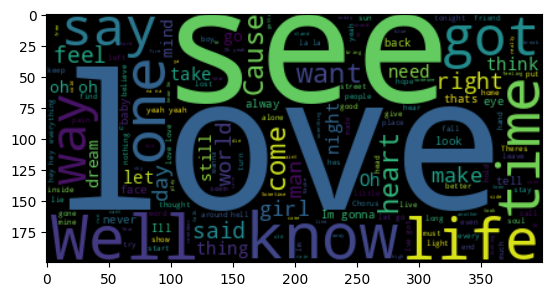

In [44]:
wordcloud = WordCloud().generate(rock_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

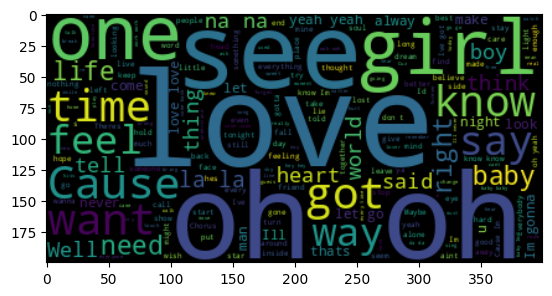

In [45]:
wordcloud = WordCloud().generate(pop_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

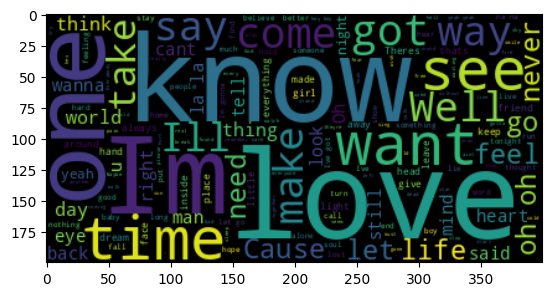

In [46]:
wordcloud = WordCloud().generate(indie_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

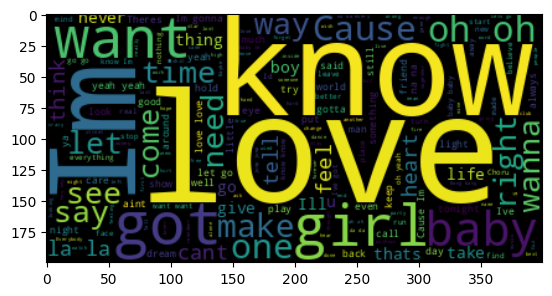

In [47]:
wordcloud = WordCloud().generate(dance_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

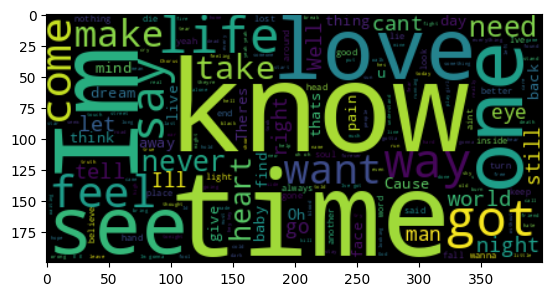

In [48]:
wordcloud = WordCloud().generate(metal_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [49]:
training_df_mdf10.sum(axis=0, skipna = True).sort_values(ascending=False).head(15)

Genre    44737.000000
im         795.567350
get        725.074007
love       613.326670
know       601.845028
like       543.496567
go         520.011775
oh         430.520378
say        415.800720
come       395.045372
see        387.237394
time       385.887904
want       384.508505
make       377.032959
never      362.689475
dtype: float64

## Models

In [50]:

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns

### Logistic Regression

We will fit, train, and predict labels using the Logistic Regression model. The logistic regression model is a linear regression model giving probability of an event occurring based on independent variables. The logit link function is used as the response for labels. The logit function is the natural log of the odds that Y equals one of the categories. The logit of Y as a response of the regression equation is:

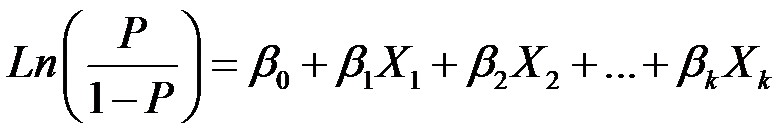

where:
- β is the coefficient based on maximum likelihood estimation (MLE)
  - Typically done with different β on multiple iterations to test for the best fit of log odds.
- X is the independent variables

For binary classification, a probability less than 0.5 will predict 0 while a probability greater than 0.5 will predict 1. In a multinomial prediction, the class prediction will be a distribution of probabilities corresponding to each label, summing to 1.

Regularization is a way to reduce overfitting of the data by the model. sklearn.linear_model.LogisticRegression() is defaulted to use L2 regularization. L2 regularization defines the regularization term as the sum of the squares of all of the feature weights:

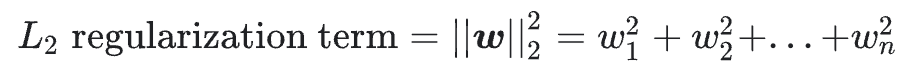

The weight w indicates the magnitude of complexity of the specific feature n. Intuitively, weights with absolute value close to 0 has little effect on model complexity while higher weights indicate that the feature is very impactful to prediction.

Split training_df_mdf10 into features and labels (X and Y). Regularization is used by default.

In [88]:
# obtaining training features and response
X_train, y_train = training_df_mdf10.iloc[:,:-1], training_df_mdf10.iloc[:,-1]


In [52]:
# Initialize LogisticRegression model for 'multi_class' classification
logreg_model_mdf10 = LogisticRegression(multi_class='multinomial', random_state=9, max_iter=300)

In [53]:
# Fit training data for min_df=10
logreg_model_mdf10.fit(X_train, y_train)

LogisticRegression(max_iter=300, multi_class='multinomial', random_state=9)

In [54]:
# Split testing data into X and Y
X_test, y_test = testing_df_mdf10.iloc[:,:-1], testing_df_mdf10.iloc[:,-1]

In [55]:
# Predict Y based on training and testing data to compare results
y_pred_mdf10 = logreg_model_mdf10.predict(X_test)
y_pred_train = logreg_model_mdf10.predict(X_train)

In [56]:
# Metrics Training on training data to see baseline fit of model on training data
print('Accuracy Training: ' + str(accuracy_score(y_train, y_pred_train)))
print('Precision Training: ' + str(precision_score(y_train, y_pred_train, average='macro')))
print('Recall Training: ' + str(recall_score(y_train, y_pred_train, average='macro')))
print('F1-Score Training: ' + str(f1_score(y_train, y_pred_train, average='macro')))

Accuracy Training: 0.6583557951482479
Precision Training: 0.6663025945146508
Recall Training: 0.6365586143720248
F1-Score Training: 0.6422239643224883


In [57]:
# Metrics for min_df=10 (minimum 10 documents the word must appear in) test
print('Accuracy Testing: ' + str(accuracy_score(y_test, y_pred_mdf10)))
print('Precision Testing: ' + str(precision_score(y_test, y_pred_mdf10, average='macro')))
print('Recall Testing: ' + str(recall_score(y_test, y_pred_mdf10, average='macro')))
print('F1-Score Testing: ' + str(f1_score(y_test, y_pred_mdf10, average='macro')))

Accuracy Testing: 0.45181058495821724
Precision Testing: 0.4174880460029738
Recall Testing: 0.45666537889237313
F1-Score Testing: 0.4115432573388804


In [58]:
matrix = confusion_matrix(y_test, y_pred_mdf10)
mat_df = pd.DataFrame(matrix,
                     index = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'],
                     columns = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'])
mat_df

,DANCE,HEAVY METAL,HIP HOP,INDIE,POP,ROCK
DANCE,44,12,22,33,52,15
HEAVY METAL,3,157,9,47,45,37
HIP HOP,16,17,770,38,97,25
INDIE,13,78,14,261,104,125
POP,82,129,84,232,479,238
ROCK,40,422,50,535,338,722


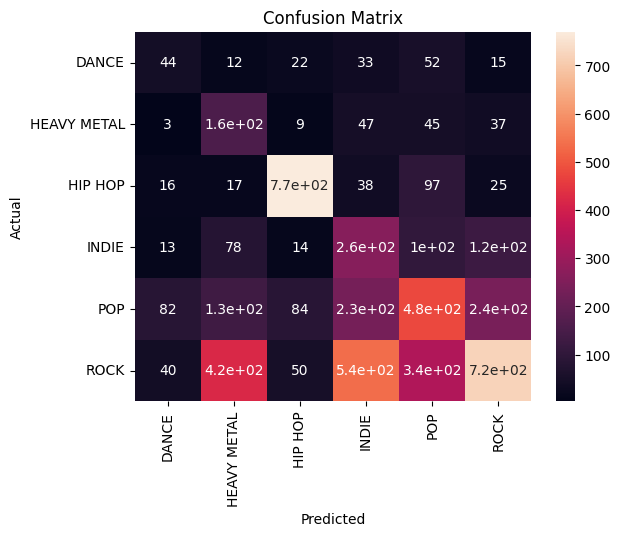

In [59]:
#Plotting the confusion matrix
sns.heatmap(mat_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [60]:
# trying with mdf 100
X_train100, y_train100 = training_df_mdf100.iloc[:,:-1], training_df_mdf100.iloc[:,-1]
X_test100, y_test100 = testing_df_mdf100.iloc[:,:-1], testing_df_mdf100.iloc[:,-1]

In [62]:
logreg_model_mdf100 = LogisticRegression(multi_class='multinomial', random_state=10, max_iter=300)
logreg_model_mdf100.fit(X_train100, y_train100)
y_pred_mdf100 = logreg_model_mdf100.predict(X_test100)
y_pred_train100 = logreg_model_mdf100.predict(X_train100)
print('Accuracy Testing: ' + str(accuracy_score(y_test100, y_pred_mdf100)))
print('Precision Testing: ' + str(precision_score(y_test100, y_pred_mdf100, average='macro')))
print('Recall Testing: ' + str(recall_score(y_test100, y_pred_mdf100, average='macro')))
print('F1-Score Testing: ' + str(f1_score(y_test100, y_pred_mdf100, average='macro')))

Accuracy Testing: 0.44326833797585885
Precision Testing: 0.40454827090139944
Recall Testing: 0.4446351606220278
F1-Score Testing: 0.3984255677806155


In [63]:
print('Accuracy Training: ' + str(accuracy_score(y_train100, y_pred_train100)))
print('Precision Training: ' + str(precision_score(y_train100, y_pred_train100, average='macro')))
print('Recall Training: ' + str(recall_score(y_train100, y_pred_train100, average='macro')))
print('F1-Score Training: ' + str(f1_score(y_train100, y_pred_train100, average='macro')))

Accuracy Training: 0.5706934574859103
Precision Training: 0.5745686652580225
Recall Training: 0.5498576935500098
F1-Score Training: 0.5539160343836099


In [64]:
matrix = confusion_matrix(y_test100, y_pred_mdf100)
mat_df = pd.DataFrame(matrix,
                     index = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'],
                     columns = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'])
mat_df

,DANCE,HEAVY METAL,HIP HOP,INDIE,POP,ROCK
DANCE,37,14,25,31,56,15
HEAVY METAL,2,158,7,46,48,37
HIP HOP,28,20,769,32,89,25
INDIE,10,87,13,245,111,129
POP,94,135,87,224,487,217
ROCK,51,414,51,537,363,691


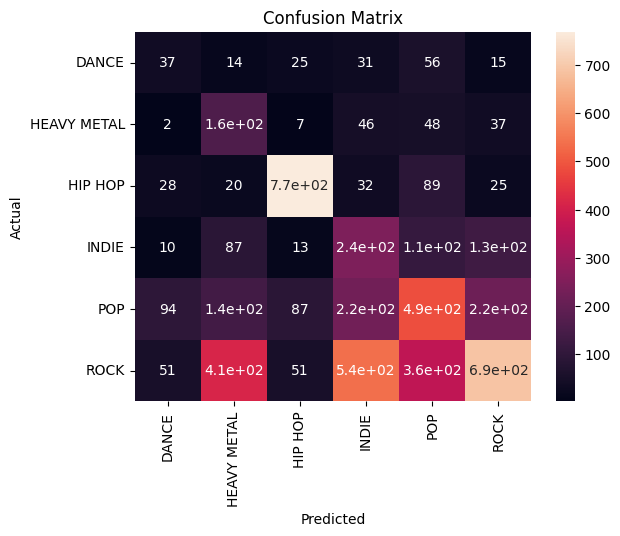

In [65]:
sns.heatmap(mat_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Random Forest Classifier

The Random Forest Classifier is an ensemble learning model that combines multiple models of decision trees to make a prediction. The classic Random Forest classifier draws sample with replacement from the training data and makes the final prediction based on majority voting. Random Forest classifiers are favored for their ability to reduce over-fitting and improve accuracy. We will examine two different criteria methods for determining quality of splits in our decision trees: "gini" for Gini impurity and "entropy" for Shannon information gain.

The "gini" formula:

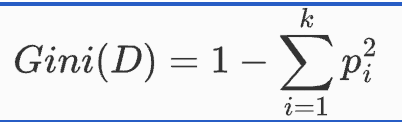

where:
- k is number of classes
- i is the class of this iteration
- p_i is probability of samples belonging to class i at a given node

The "entropy" formula:

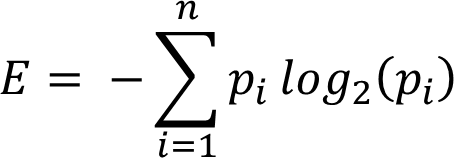

where:
- n is the number of classes
- i is for the class of this iteration
- p_i is the probability of samples belonging to class i at a given node

The model we will use has default settings for

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [67]:
num_of_trees = [10,50,100,200,400,600,800]

# creates different-sized random forest classifiers using gini split
# calculates accuracy, precision, recall, f1 score, and AUC metrics for each random forest
# on testing and training data
for tree_num in num_of_trees:

    # Initialize RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=tree_num)
    # fit classifier with training data
    rf.fit(X_train100, y_train100)
    # predict labels for training data
    y_pred_tr = rf.predict(X_train100)
    # predict labels for testing data using training data fit
    y_pred_te = rf.predict(X_test100)

    # prints evaluation metrics on logistic regression model results
    print(f'Accuracy, F1 score, and AUC for Random Forest on Training data tree size={tree_num}')
    print('Accuracy score:', accuracy_score(y_train100, y_pred_tr))
    print('Precision score:', precision_score(y_train100, y_pred_tr, average='macro'))
    print('Recall score:', recall_score(y_train100, y_pred_tr, average='macro'))
    print('F1 score:', f1_score(y_train100, y_pred_tr, average='macro'))
    # AUC for random forest on training data
    rf_probs_tr = rf.predict_proba(X_train100)
    print('AUC score:', roc_auc_score(y_train100, rf_probs_tr, multi_class='ovr'))

    print(f'Accuracy, F1 score, and AUC for Random Forest on Testing data tree size={tree_num}')
    print('Accuracy score:', accuracy_score(y_test100, y_pred_te))
    print('Precision score:', precision_score(y_test100, y_pred_te, average='macro'))
    print('Recall score:', recall_score(y_test100, y_pred_te, average='macro'))
    print('F1 score:', f1_score(y_test100, y_pred_te, average='macro'))
    # AUC for random forest on testing data
    rf_probs_te = rf.predict_proba(X_test100)
    print('AUC score:', roc_auc_score(y_test100, rf_probs_te, multi_class='ovr'))
    print('\n')

Accuracy, F1 score, and AUC for Random Forest on Training data tree size=10
Accuracy score: 0.9894633668218574
Precision score: 0.9893281954901991
Recall score: 0.9892654754403337
F1 score: 0.9892837695893034
AUC score: 0.9995715660101628
Accuracy, F1 score, and AUC for Random Forest on Testing data tree size=10
Accuracy score: 0.36675951717734445
Precision score: 0.34445457429571497
Recall score: 0.3802624500325365
F1 score: 0.3305502210511236
AUC score: 0.6943467620001789


Accuracy, F1 score, and AUC for Random Forest on Training data tree size=50
Accuracy score: 0.9983459936290126
Precision score: 0.9982429198474181
Recall score: 0.9983409300708311
F1 score: 0.9982916186508541
AUC score: 0.9999845662186718
Accuracy, F1 score, and AUC for Random Forest on Testing data tree size=50
Accuracy score: 0.4293407613741876
Precision score: 0.4044812558814274
Recall score: 0.4182522648528095
F1 score: 0.3838328414422103
AUC score: 0.7576317880224505


Accuracy, F1 score, and AUC for Random F

In [68]:
num_of_trees = [10,100,200,400,600]

# creates different-sized random forest classifiers using entropy split
# calculates accuracy, precision, recall, f1 score, and AUC metrics for each random forest
# on testing and training data
for tree_num in num_of_trees:

    # Initialize RandomForectClassifier using entropy split
    rf = RandomForestClassifier(n_estimators=tree_num, criterion='entropy')
    # fit classifier with training data
    rf.fit(X_train100, y_train100)
    # predict labels for training data
    y_pred_tr = rf.predict(X_train100)
    # predict labels for testing data using training data fit
    y_pred_te = rf.predict(X_test100)

    # prints evaluation metrics on logistic regression model results
    print(f'Accuracy, F1 score, and AUC for Random Forest on Training data tree size={tree_num}')
    print('Accuracy score:', accuracy_score(y_train100, y_pred_tr))
    print('Precision score:', precision_score(y_train100, y_pred_tr, average='macro'))
    print('Recall score:', recall_score(y_train100, y_pred_tr, average='macro'))
    print('F1 score:', f1_score(y_train100, y_pred_tr, average='macro'))
    # AUC for random forest on training data
    rf_probs_tr = rf.predict_proba(X_train100)
    print('AUC score:', roc_auc_score(y_train100, rf_probs_tr, multi_class='ovr'))

    print(f'Accuracy, F1 score, and AUC for Random Forest on Testing data tree size={tree_num}')
    print('Accuracy score:', accuracy_score(y_test100, y_pred_te))
    print('Precision score:', precision_score(y_test100, y_pred_te, average='macro'))
    print('Recall score:', recall_score(y_test100, y_pred_te, average='macro'))
    print('F1 score:', f1_score(y_test100, y_pred_te, average='macro'))
    # AUC for random forest on testing data
    rf_probs_te = rf.predict_proba(X_test100)
    print('AUC score:', roc_auc_score(y_test100, rf_probs_te, multi_class='ovr'))
    print('\n')

Accuracy, F1 score, and AUC for Random Forest on Training data tree size=10
Accuracy score: 0.9905660377358491
Precision score: 0.9908684520769043
Recall score: 0.9902761521747956
F1 score: 0.9905583517079076
AUC score: 0.9996356445440385
Accuracy, F1 score, and AUC for Random Forest on Testing data tree size=10
Accuracy score: 0.3600742804085422
Precision score: 0.33744978583064306
Recall score: 0.37894303431306037
F1 score: 0.324155072447608
AUC score: 0.6969699144397095


Accuracy, F1 score, and AUC for Random Forest on Training data tree size=100
Accuracy score: 0.9983459936290126
Precision score: 0.9983035453308148
Recall score: 0.9982807889381334
F1 score: 0.9982916721330711
AUC score: 0.9999882122933298
Accuracy, F1 score, and AUC for Random Forest on Testing data tree size=100
Accuracy score: 0.43342618384401116
Precision score: 0.425899879639465
Recall score: 0.42259027524007015
F1 score: 0.38791745657892357
AUC score: 0.7783579193612492


Accuracy, F1 score, and AUC for Rando

In [69]:
# gini with 400 trees is best:
rf = RandomForestClassifier(n_estimators=400)
rf.fit(X_train100, y_train100)
y_pred_tr = rf.predict(X_train100)
y_pred_te = rf.predict(X_test100)


In [70]:
matrix = confusion_matrix(y_test100, y_pred_te)
mat_df = pd.DataFrame(matrix,
                     index = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'],
                     columns = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'])
mat_df

,DANCE,HEAVY METAL,HIP HOP,INDIE,POP,ROCK
DANCE,22,5,32,26,76,17
HEAVY METAL,0,136,12,54,60,36
HIP HOP,3,9,821,33,76,21
INDIE,2,67,18,290,95,123
POP,10,99,119,235,572,209
ROCK,4,359,57,634,380,673


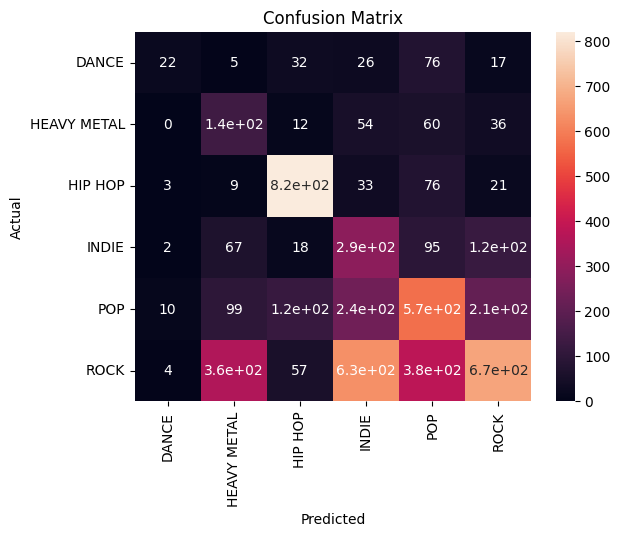

In [71]:
sns.heatmap(mat_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### AdaBoost Classifier

AdaBoost Classifier is a type of weak ensemble learner that enhances the accuracy of prediction by iteratively focusing on wrongly classified samples. It does so by weighting wrongly classified points higher in the subsequent model, assigning more importance to that point in the next model.

AdaBoost assigns weights to each data point using the following formula:

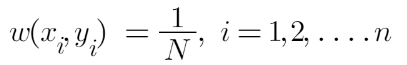

We will use a low-level DecisionTreeClassifier known as a "stump" as the base model for AdaBoost. A "stump" is a Decision Tree that only considers one feature to make one level of decision. The "influence" of the feature being considered at each "stump" gives a sense of how "important" said feature is at differentiating the prediction. The formula for "influence" is as follows:

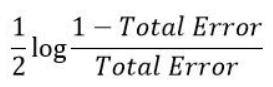

The weight assigned to the data points for the next "stump" is calculated with:
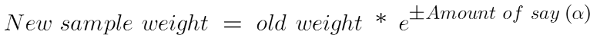

where 'Amount of say' is the 'influence' metric. The new sample weight of a misclassified data point will use a positive 'influence' while correctly classified data points will use a negative 'influence'.

In [87]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

In [73]:
num_of_bases = [10,100,200]

for bases in num_of_bases:

    # initializes decision tree classifier base
    sb_dt = tree.DecisionTreeClassifier()
    # use the number of base classifiers for this loop
    ada_ = AdaBoostClassifier(sb_dt, n_estimators=bases)
    # fit training data with min_df=100
    ada_.fit(X_train100, y_train100)

    # predicts y from x_train and x_test
    ypred_train = ada_.predict(X_train100)
    ypred_test = ada_.predict(X_test100)

    # prints accuracy, F1 score, and AUC for AdaBoostClassifier on training data
    print(f'Evaluation Metrics for AdaBoostClassifier Training Data boost size={bases}')
    print('Accuracy score:', accuracy_score(y_train100, ypred_train))
    print('Precision score:', precision_score(y_train100, ypred_train, average='macro'))
    print('Recall score:', recall_score(y_train100, ypred_train, average='macro'))
    print('F1 score:', f1_score(y_train100, ypred_train, average='macro'))
    # AUC for random forest on training data
    ada_probs_tr = ada_.predict_proba(X_train100)
    print('AUC score:', roc_auc_score(y_train100, ada_probs_tr, average='macro', multi_class='ovr'))
    # prints accuracy, F1 score, and AUC for AdaBoostClassifier on testing data
    print(f'Evaluation Metrics for AdaBoostClassifier Testing Data boost size={bases}')
    print('Accuracy score:', accuracy_score(y_test100, ypred_test))
    print('Precision score:', precision_score(y_test100, ypred_test, average='macro'))
    print('Recall score:', recall_score(y_test100, ypred_test, average='macro'))
    print('F1 score:', f1_score(y_test100, ypred_test, average='macro'))
    # AUC for random forest on testing data
    ada_probs_te = ada_.predict_proba(X_test100)
    print('AUC score:', roc_auc_score(y_test100, ada_probs_te, average='macro', multi_class='ovr'))
    print('\n')

Evaluation Metrics for AdaBoostClassifier Training Data boost size=10
Accuracy score: 0.9983459936290126
Precision score: 0.9980979328860061
Recall score: 0.9984893232655382
F1 score: 0.9982922435716565
AUC score: 0.9999988339134817
Evaluation Metrics for AdaBoostClassifier Testing Data boost size=10
Accuracy score: 0.34447539461467036
Precision score: 0.3208535507609717
Recall score: 0.3329730914578875
F1 score: 0.30365173350642244
AUC score: 0.6629026167879061


Evaluation Metrics for AdaBoostClassifier Training Data boost size=100
Accuracy score: 0.9983459936290126
Precision score: 0.9980979328860061
Recall score: 0.9984893232655382
F1 score: 0.9982922435716565
AUC score: 0.9999988339134817
Evaluation Metrics for AdaBoostClassifier Testing Data boost size=100
Accuracy score: 0.3532033426183844
Precision score: 0.3259242782847979
Recall score: 0.34136453012057055
F1 score: 0.3115440384620691
AUC score: 0.6499915612126433


Evaluation Metrics for AdaBoostClassifier Training Data boost

In [75]:
matrix = confusion_matrix(y_test100, ypred_test)
mat_df = pd.DataFrame(matrix,
                     index = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'],
                     columns = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'])
mat_df

,DANCE,HEAVY METAL,HIP HOP,INDIE,POP,ROCK
DANCE,33,23,29,27,33,33
HEAVY METAL,19,90,14,60,52,63
HIP HOP,66,51,647,46,98,55
INDIE,27,107,27,188,117,129
POP,148,204,98,209,343,242
ROCK,109,401,84,542,390,581


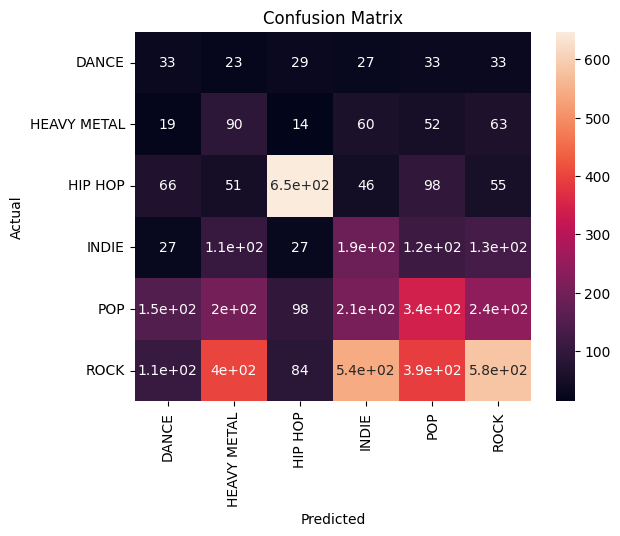

In [76]:
sns.heatmap(mat_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Naive Bayes Classifier

The Naive Bayes Classifier is based on Bayes' Theorem which assumes independence between predictors. The presence of a particular feature is unrelated to the presence of another feature. Despite this assumption rarely applying to real-life scenarios, the Naive Bayes Classifier is widely used, having been proven to be efficient and high-performant.

Bayes' Theorem is based on the following formula:

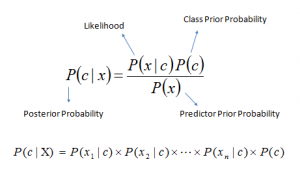

where:
- P(c|x) is the posterior probability of class (c, target) given predictor (x, attributes).
- P(c) is the prior probability of class.
- P(x|c) is the likelihood which is the probability of the predictor given class.
- P(x) is the prior probability of the predictor.

Our experiment will use MultinomialNB which implements naive Bayes algorithm for multinomially distributed data, such as in our problem.

In [77]:
# multinomial naive bayes- our features are frequencies
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
preds_nb = nb.predict(X_test)
preds_nb_train = nb.predict(X_train)


In [78]:
# training scores
print('Accuracy Training: ' + str(accuracy_score(y_train, preds_nb_train)))
print('Precision Training: ' + str(precision_score(y_train, preds_nb_train, average='macro')))
print('Recall Training: ' + str(recall_score(y_train, preds_nb_train, average='macro')))
print('F1-Score Training: ' + str(f1_score(y_train, preds_nb_train, average='macro')))

Accuracy Training: 0.5778608184268562
Precision Training: 0.6617071909211657
Recall Training: 0.5369900839983127
F1-Score Training: 0.5228069443190901


In [79]:
# testing scores
print('Accuracy Testing: ' + str(accuracy_score(y_test, preds_nb)))
print('Precision Testing: ' + str(precision_score(y_test, preds_nb, average='macro')))
print('Recall Testing: ' + str(recall_score(y_test, preds_nb, average='macro')))
print('F1-Score Testing: ' + str(f1_score(y_test, preds_nb, average='macro')))

Accuracy Testing: 0.4503249767873723
Precision Testing: 0.48785098395735105
Recall Testing: 0.41654448696475704
F1-Score Testing: 0.3734938983865266


In [ ]:
matrix = confusion_matrix(y_test, preds_nb)
mat_df = pd.DataFrame(matrix,
                     index = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'],
                     columns = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'])
mat_df

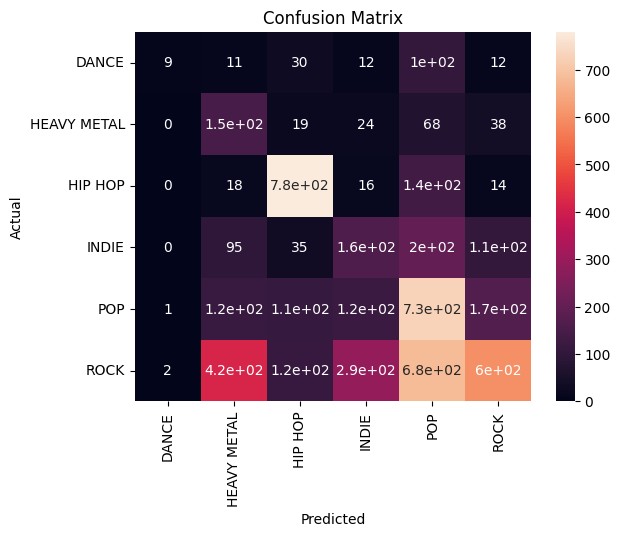

In [81]:
sns.heatmap(mat_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [82]:
# with mdf-100
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train100, y_train100)
preds_nb100 = nb.predict(X_test100)
preds_nb_train100 = nb.predict(X_train100)

In [83]:
# training scores
print('Accuracy Training: ' + str(accuracy_score(y_train100, preds_nb_train100)))
print('Precision Training: ' + str(precision_score(y_train100, preds_nb_train100, average='macro')))
print('Recall Training: ' + str(recall_score(y_train100, preds_nb_train100, average='macro')))
print('F1-Score Training: ' + str(f1_score(y_train100, preds_nb_train100, average='macro')))

Accuracy Training: 0.5017152658662093
Precision Training: 0.5330498423218097
Recall Training: 0.46870663337798896
F1-Score Training: 0.4580388812034734


In [84]:
print('Accuracy Testing: ' + str(accuracy_score(y_test100, preds_nb100)))
print('Precision Testing: ' + str(precision_score(y_test100, preds_nb100, average='macro')))
print('Recall Testing: ' + str(recall_score(y_test100, preds_nb100, average='macro')))
print('F1-Score Testing: ' + str(f1_score(y_test100, preds_nb100, average='macro')))

Accuracy Testing: 0.4380687093779016
Precision Testing: 0.39055381398472755
Recall Testing: 0.40960632047390066
F1-Score Testing: 0.36563362741638855


In [85]:
matrix = confusion_matrix(y_test100, preds_nb100)
mat_df = pd.DataFrame(matrix,
                     index = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'],
                     columns = ['DANCE','HEAVY METAL','HIP HOP','INDIE','POP','ROCK'])
mat_df

,DANCE,HEAVY METAL,HIP HOP,INDIE,POP,ROCK
DANCE,8,14,30,21,94,11
HEAVY METAL,0,141,22,47,51,37
HIP HOP,6,20,769,22,128,18
INDIE,1,100,36,207,160,91
POP,13,118,105,188,630,190
ROCK,12,430,121,406,534,604


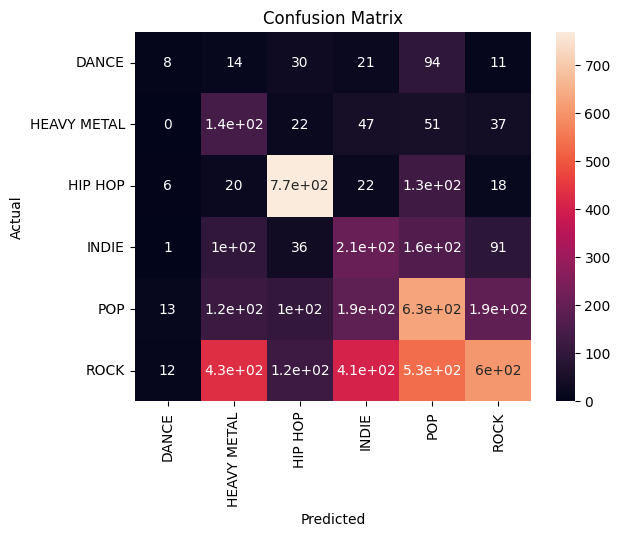

In [86]:
sns.heatmap(mat_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()